In [16]:
# Install packages
!pip install boto3 pandas pyathena
!pip install markov_clustering
!pip install xlrd
!pip install numpy
import numpy as np
import markov_clustering as mc
import networkx as nx
!pip install scipy
!pip install scikit-learn
import scipy
import pandas as pd
import boto3
import pyathena
import time

In [3]:
# Save locations of some of our AWS info
CLIENT = boto3.client("athena")
DATABASE_NAME = "ncbi-vcf-codeathon-rc-db1"
RESULT_OUTPUT_LOCATION = "s3://ncbi-vcf-codeathon-rc-athena/"

In [4]:
query ="WITH meta AS ( \
    SELECT acc AS run, biosample, bioproject \
    FROM \"metadata\" \
    WHERE cast(collection_date_sam[1] AS date) >= date_parse('2022-01-01', '%Y-%m-%d') \
), \
variations AS ( \
    SELECT run, POS, concat(ref, cast(pos AS varchar), alt) AS variation, concat(protein_name, cast(':' AS varchar), variation) AS aa_change \
    FROM \"annotated_variations\" \
    JOIN meta USING(run) \
    WHERE G_AD_2/DP >= 0.5 AND G_AD_2 >= 50 AND DP >= 100 AND protein_name = concat('S','') AND alt_aa IS NOT NULL \
), \
records AS ( \
    SELECT count(distinct run) AS runs \
    FROM variations \
), \
variation_totprobs AS ( \
    SELECT row_number() OVER(PARTITION BY NULL ORDER BY variation) AS rown, \
           variation, \
           count(distinct run) AS var_tot, \
           count(distinct run)/(SELECT runs FROM records) AS var_prob \
    FROM variations \
    GROUP BY variation \
    ORDER BY variation \
), \
var_pairs AS ( \
    SELECT v1.run, \
           v1.variation AS variation_1, \
           v2.variation AS variation_2, \
           v1.aa_change AS aa_change_1, \
           v2.aa_change AS aa_change_2, \
           v3.var_tot AS var_tot_1, \
           v4.var_tot AS var_tot_2, \
           v3.var_prob AS var_prob_1, \
           v4.var_prob AS var_prob_2 \
    FROM variations v1 \
    JOIN variations v2 ON v1.run = v2.run \
    JOIN variation_totprobs v3 ON v1.variation = v3.variation \
    JOIN variation_totprobs v4 ON v2.variation = v4.variation \
    WHERE v1.variation != v2.variation AND v3.rown < v4.rown \
), \
results as ( \
    select v0.variation_1, \
       v0.variation_2, \
       aa_change_1, \
       aa_change_2, \
       var_tot_1 as var_1_count, \
       var_tot_2 as var_2_count, \
       least(var_tot_1, var_tot_2) as max_records_possible, \
       count(distinct v0.run) as record_count, \
       count(distinct biosample) as samples, \
       count(distinct bioproject) as projects, \
       count(distinct v0.run) / (select runs from records) as record_freq, \
       (select runs from records) * count(distinct v0.run) / (var_tot_1 * var_tot_2) as rel_record_freq, \
       count(distinct v0.run) / (var_tot_1) as con_prob_1, \
       count(distinct v0.run) / (var_tot_2) as con_prob_2, \
       count(distinct v0.run) / (var_tot_1 + var_tot_2 - count(distinct v0.run)) as jaccard, \
       (((var_tot_1 - count(distinct v0.run))*((1 - var_prob_1)*(-1*var_prob_2)))+((var_tot_2 - count(distinct v0.run))*((-1*var_prob_1)*(1-var_prob_2)))+(count(distinct v0.run)*((1-var_prob_1)*(1-var_prob_2))))/sqrt((((var_tot_1 - count(distinct v0.run))*((1 - var_prob_1)*(1 - var_prob_2))+((var_tot_2 - count(distinct v0.run))*((-1*var_prob_1)*(-1*var_prob_2)))+(count(distinct v0.run)*((1-var_prob_1)*(1-var_prob_2)))))*((var_tot_1 - count(distinct v0.run))*((-1*var_prob_1)*(-1*var_prob_2))+((var_tot_2 - count(distinct v0.run))*((1-var_prob_1)*(1-var_prob_2)))+(count(distinct v0.run)*((1-var_prob_1)*(1-var_prob_2))))) as pearson \
    from var_pairs v0 \
    join meta m on m.run = v0.run \
    where var_prob_1 != 1 \
    group by variation_1, variation_2, var_tot_1, var_tot_2, var_prob_1, var_prob_2, aa_change_1, aa_change_2 \
) \
select * \
from results \
where max_records_possible >100 and \
        samples > 100 and \
        projects >2 and \
        ((rel_record_freq > 1.5) or (rel_record_freq < 1/1.5) or \
        (jaccard > 1.5*con_prob_1*con_prob_2 or jaccard < 0.5*con_prob_1*con_prob_2 or con_prob_1>0.99 or con_prob_1<0.01 or con_prob_2>0.99 or con_prob_2<0.01 or jaccard>0.9 or jaccard<0.1 ) or \
        (pearson > 1/10 or pearson < -1/10))"

In [8]:
response = CLIENT.start_query_execution(
    QueryString=query,
    QueryExecutionContext={
        'Database': DATABASE_NAME  # Replace with your Athena database name
    },
    ResultConfiguration={
        'OutputLocation': RESULT_OUTPUT_LOCATION  # Replace with your S3 bucket path
    }
)

# Get the query execution ID
query_execution_id = response['QueryExecutionId']

# Function to check the status of the query execution
def is_query_running(query_execution_id):
    response = CLIENT.get_query_execution(QueryExecutionId=query_execution_id)
    state = response['QueryExecution']['Status']['State']
    return state in ['QUEUED', 'RUNNING']

# Wait for the query to complete
while is_query_running(query_execution_id):
    time.sleep(5)  # Wait for 5 seconds before checking again

# Get the results from Athena using get_query_results
response = CLIENT.get_query_results(QueryExecutionId=query_execution_id)

# Convert the results to a Pandas DataFrame
column_names = [col['Name'] for col in response['ResultSet']['ResultSetMetadata']['ColumnInfo']]
data_rows = [list(row['VarCharValue'] for row in result['Data']) for result in response['ResultSet']['Rows'][1:]]
data = pd.DataFrame(data_rows, columns=column_names)

data.head()

,variation_1,variation_2,aa_change_1,aa_change_2,var_1_count,var_2_count,max_records_possible,record_count,samples,projects,record_freq,rel_record_freq,con_prob_1,con_prob_2,jaccard,pearson
0,C21618T,C23604A,S:T19I,S:P681H,648353,935813,648353,371056,370911,138,0,1,0,0,0,0.4763642477408121
1,A22688G,A23013C,S:T376A,S:E484A,242178,884921,242178,185266,185266,100,0,1,0,0,0,0.400199120689648
2,A23063T,TTATTA21991TTA,S:N501Y,S:YY144Y,928802,17590,17590,9379,9379,53,0,1,0,0,0,0.07337735369769248
3,A22320G,A23403G,S:D253G,S:D614G,651,547233,651,398,398,27,0,2,0,0,0,0.021086594101415987
4,G22317T,T24469A,S:G252V,S:N969K,21861,360368,21861,9067,9067,36,0,2,0,0,0,0.10215402753976317


In [13]:
simple_data=data[['variation_1', 'variation_2', 'pearson']]
simple_data.shape

(999, 3)

In [18]:
# Extract the variations and the Pearson correlation coefficients from your DataFrame
variations = data[['variation_1', 'variation_2']]
pearson_coefficients = data['pearson'].astype(float)

# Create a square matrix with zeros
num_variations = len(variations)
similarity_matrix = np.zeros((num_variations, num_variations))

# Fill the similarity matrix with the Pearson correlation coefficients
for i in range(num_variations):
    for j in range(num_variations):
        similarity_matrix[i, j] = pearson_coefficients[i] if i == j else pearson_coefficients[j]

# Normalize the similarity matrix
scaler = MinMaxScaler()
normalized_similarity_matrix = scaler.fit_transform(similarity_matrix)

# Perform Markov Clustering
# The 'inflation' parameter controls the granularity of the clusters
result = mc.run_mcl(normalized_similarity_matrix, inflation=2)
clusters = mc.get_clusters(result)

# Map the clusters back to the gene variations
clustered_variations = []
for cluster in clusters:
    variations_in_cluster = variations.iloc[cluster]
    clustered_variations.append(variations_in_cluster)


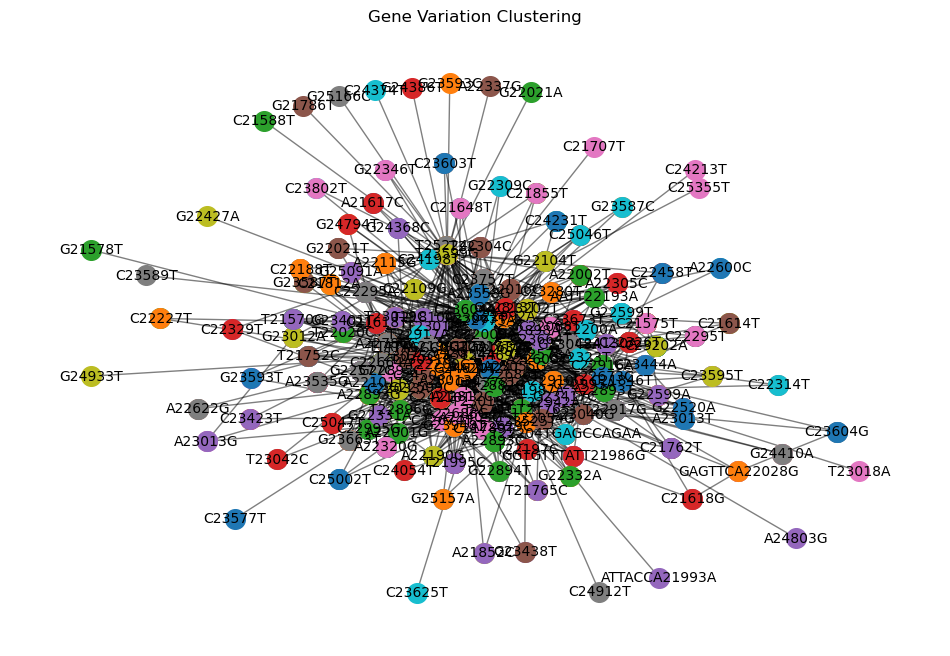

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph to visualize the clusters
G = nx.Graph()

# Add nodes (variations) to the graph
for i, cluster in enumerate(clustered_variations):
    for variation in cluster.values.flatten():
        G.add_node(variation, cluster=i)

# Add edges between nodes in the same cluster
for cluster in clustered_variations:
    for i, variation1 in enumerate(cluster.values.flatten()):
        for j, variation2 in enumerate(cluster.values.flatten()):
            if i != j:
                G.add_edge(variation1, variation2)

# Position the nodes using the spring layout algorithm
pos = nx.spring_layout(G)

# Draw the graph without the legend
plt.figure(figsize=(12, 8))
for i, cluster in enumerate(clustered_variations):
    nodes = cluster.values.flatten()
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=f"C{i}", node_size=200)

# Draw the edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Optionally, you can add labels to the nodes
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Gene Variation Clustering")
plt.axis("off")
plt.show()



In [ ]:
# Save the figure as a PNG image
plt.savefig("gene_variation_clustering.png", dpi=300, bbox_inches="tight")
